# CarNet

Welcome to the final assignment in this course. It's been a long journey, but you are now ready to unleash the powers of neural networks at any task. In this assignment, we will be working with a collection of photos related to driving vehicles.

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import optimizers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_context('talk')
%config InlineBackend.figure_format = 'retina'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Description of the Solution

* The task was to predict the number of signal lights and vehicles in images. Average MSE of both outputs is used as the main metric.
* We trained 3 models and tried different stacking methods for ensemble.
* The 3 models are:
    * Mean model: we used the mean of training dataset to infer the values. This one is our base model.
    * Transfer learning: we used mobilenet, with finetuning executed.
    * Vanilla CNN: we built a cnn model from scratch.
    * Both mobilenet and vanilla CNN have shown better results than mean model.
* For stacking, we tried:
    * simple average of output from all 3 models and the last 2 models
    * individual linear regression on signal and vehicle with output from mobilenet and vanilla CNN
    * XGBoost on all 3 outputs together
    * NN from scratch
    * The result shows that XGBoost has the best result and it is better than the single models above
* We created a `final_model` class to aggregate the 3 models and predict on the score dataset.
* We didn't use ML Flow for hyperparameter tuning in this project. Although it's efficient to automate the hyperparamter tuning process, changing the hyperparameters one by one manually helps better understand their impacts on the model results. Observing the changes is an import part of learning.

# Download Data

The dataset consists of 2 segments: 
* train: the metadata file contains the file names and the count of different objects in each image.
* score: the metadata file contains the file names of images to be used for the final predictions.

Target variables (in this order):
1. signal
2. vehicle

These target variables are defined as follows:
* signal =  traffic light + stop sign
* vehicle = car + bus + truck + train + motorcycle + bicycle + airplane + boat

In [4]:
if not os.path.exists('carnet_dataset'):
    !aws s3 cp s3://danylo-ucla/carnet_dataset.zip ./
    !unzip -u -q carnet_dataset.zip

In [5]:
!tree -L 2 carnet_dataset

carnet_dataset
├── score
│   ├── images
│   └── metadata.csv
└── train
    ├── images
    └── metadata.csv

4 directories, 2 files


In [6]:
train_metadata = pd.read_csv('carnet_dataset/train/metadata.csv')
train_metadata.head()

,car,bus,truck,train,motorcycle,bicycle,airplane,boat,traffic light,stop sign,vehicle,signal,file_name
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,000000000064.jpg
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,000000000073.jpg
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000074.jpg
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,000000000081.jpg
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000086.jpg


In [7]:
# Score metadata defines the expected order of the photos in the submitted predictions file.

score_metadata = pd.read_csv('carnet_dataset/score/metadata.csv')
score_metadata.head()

,file_name
0,000000000071.jpg
1,000000000149.jpg
2,000000000260.jpg
3,000000000307.jpg
4,000000000690.jpg


# Read data

In [8]:
random.seed(43)

([], [])

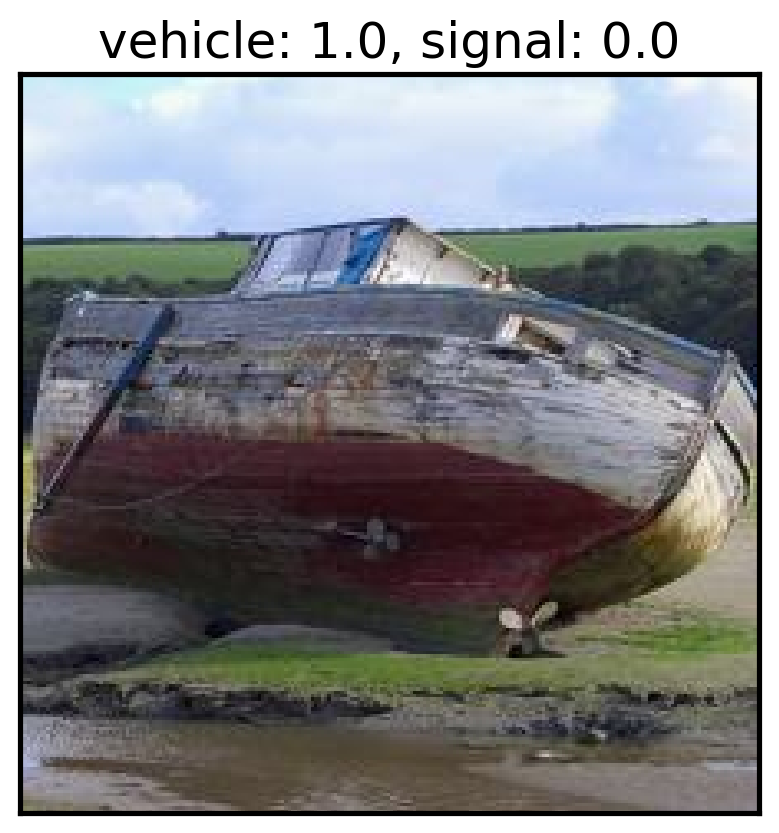

In [9]:
i = random.randint(0, train_metadata.shape[0])

file_name_training = train_metadata['file_name'].iloc[i]

vehicle_num = train_metadata['vehicle'].iloc[i]
signal_num = train_metadata['signal'].iloc[i]

plt.title(f'vehicle: {vehicle_num}, signal: {signal_num}')


plt.imshow(Image.open(f'carnet_dataset/train/images/{file_name_training}'))
plt.xticks([])
plt.yticks([])

## Generate TF Dataset

In [10]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_labeled(metadata: pd.DataFrame):
    def generator():
        for _, row in metadata.iterrows():
            
            # get image
            file_path = 'carnet_dataset/train/images/' + row['file_name']
            training_np = np.array(Image.open(file_path)).astype(np.float32)
            
            # get number of vehicles and signals
            signal_num = row['signal']
            vehicle_num = row['vehicle']
            
            
            model_input = training_np
            model_output = (signal_num, vehicle_num)
            yield (model_input, model_output)


    return generator


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_labeled(metadata: pd.DataFrame) -> tf.data.Dataset:
    model_input = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore
    model_output = tf.TensorSpec(shape=(2,), dtype=tf.float32)  # type: ignore

    dataset_signature = (model_input, model_output)

    dataset = tf.data.Dataset.from_generator(
        build_generator_labeled(metadata), 
        output_signature=dataset_signature
    )

    return dataset


## Split metadata

In [11]:
train_ratio = 0.7
val_ratio = 0.15

# Determine the number of samples for each set
# total_samples = train_metadata.shape[0]

# num_train = int(train_ratio * total_samples)
# num_val = int(val_ratio * total_samples)

# train_md = train_metadata.iloc[:num_train]
# val_md = train_metadata.iloc[num_train:num_train + num_val]
# test_md = train_metadata.iloc[num_train + num_val:]

In [12]:
from sklearn.model_selection import train_test_split

# Shuffle the dataset
shuffled_metadata = train_metadata.sample(frac=1, random_state=42)  # Setting a random seed for reproducibility

# Split the shuffled dataset into training, validation, and test sets
train_md, val_test_md = train_test_split(shuffled_metadata, train_size=train_ratio, random_state=42)
val_md, test_md = train_test_split(val_test_md, train_size=val_ratio/(1-train_ratio), random_state=42)

In [14]:
train_metadata.shape

(23228, 13)

In [13]:
train_md.shape, val_md.shape, test_md.shape

((16259, 13), (3484, 13), (3485, 13))

In [15]:
train_dataset = build_dataset_labeled(train_md)
val_dataset = build_dataset_labeled(val_md)
test_dataset = build_dataset_labeled(test_md)

In [16]:
train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)

In [17]:
train_X, train_y = next(iter(train_dataset))
val_X, val_y = next(iter(val_dataset))
test_X, test_y = next(iter(test_dataset))

In [18]:
display(train_X.shape, train_y.shape)
display(val_X.shape, val_y.shape)
display(test_X.shape, test_y.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 2])

TensorShape([16, 224, 224, 3])

TensorShape([16, 2])

TensorShape([16, 224, 224, 3])

TensorShape([16, 2])

# Assitant functions

In [19]:
def plot_learning_curve(history):
    learning_curve_train = pd.Series(history.history['loss'])
    learning_curve_val = pd.Series(history.history['val_loss'])
    learning_curve_train.index = learning_curve_train.index + 1
    learning_curve_val.index = learning_curve_val.index + 1

    plt.plot(learning_curve_train, label='Train')
    plt.plot(learning_curve_val, label='Val')
    
    plt.xticks(learning_curve_train.index)
    plt.legend()
    plt.show()

In [20]:
from tensorflow import Tensor
from tensorflow.python.keras import backend as K

def avg_mse(y_true: Tensor, y_pred: Tensor) -> Tensor:
    
    signal_mse = K.mean(K.square(
    y_true[:, 0] - y_pred[:, 0]))
    vehicle_mse = K.mean(K.square(
    y_true[:, 1] - y_pred[:, 1]))
    
    avg_mse = 1/2 * signal_mse + 1/2 * vehicle_mse
    
    return avg_mse

def signal_mse(y_true: Tensor, y_pred: Tensor) -> Tensor:
    
    signal_mse = K.mean(K.square(
    y_true[:, 0] - y_pred[:, 0]))
    
    return signal_mse

def vehicle_mse(y_true: Tensor, y_pred: Tensor) -> Tensor:
    
    vehicle_mse = K.mean(K.square(
    y_true[:, 1] - y_pred[:, 1]))
    
    
    return vehicle_mse

# Single model tuning

## Mean model

In [21]:
from sklearn.metrics import mean_squared_error


def mean_model_result(train_md, md):
    y_signal = md['signal']
    y_vehicle = md['vehicle']

    y_train_mean_signal = [train_md['signal'].mean()] * md.shape[0]
    y_train_mean_vehicle = [train_md['vehicle'].mean()] * md.shape[0]


    mse_train_signal = mean_squared_error(y_signal, y_train_mean_signal)

    mse_train_vehicle = mean_squared_error(y_vehicle, y_train_mean_vehicle)
    
    # y_train_mean = np.concatenate((y_train_mean_signal, y_train_mean_vehicle))
    y_train_mean = np.array([y_train_mean_signal, y_train_mean_vehicle]).T

    return (y_train_mean,
        (mse_train_signal, mse_train_vehicle, 1/2 * mse_train_signal + 1/2 * mse_train_vehicle))

In [22]:
y_train_mean, mean_results_train = mean_model_result(train_md, train_md)
mean_results_train

(2.1968980652957457, 13.604800635551241, 7.900849350423494)

In [23]:
y_val_mean, mean_results_val = mean_model_result(train_md, val_md)
mean_results_val

(2.1244298238274317, 14.457199575018347, 8.290814699422889)

In [24]:
y_test_mean, mean_results_test = mean_model_result(train_md, test_md)
mean_results_test

(2.16425383353561, 13.092209359486931, 7.62823159651127)

In [25]:
np.savez('y_mean.npz', y_train_mean=y_train_mean,
        y_val_mean=y_val_mean, y_test_mean=y_test_mean)

## mobilenet

In [26]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
)

mobile_net.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [40]:
%%time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers

model1 = keras.models.Sequential([
            mobile_net,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=2)
        ]
        )
print(model1.summary())

model1.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='mean_squared_error',
    metrics=[signal_mse, vehicle_mse, avg_mse],
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 2,383,426
Trainable params: 1,986,882
Non-trainable params: 396,544
_________________________________________________________________
None
CPU times: user 311 ms, sys: 3.2 ms, total: 315 ms
Wall time: 310 ms


In [27]:
history1 = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,
    shuffle=False
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 2)                 125442    
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/2
1017/1017 [==============================] - 169s 162ms/step - loss: 8.0607 - signal_mse: 2.6832 - vehicle_mse: 13.4324 - avg_mse: 8.0578 - val_loss: 7.8944 - val_signal_mse: 2.4494 - val_vehicle_mse: 13.3484 - val_avg_mse:

In [28]:
model1.evaluate(train_dataset)
model1.evaluate(val_dataset)
model1.evaluate(test_dataset)

218/218 [==============================] - 29s 132ms/step - loss: 7.2430 - signal_mse: 2.3775 - vehicle_mse: 12.1035 - avg_mse: 7.2405


[7.243016242980957, 2.3775126934051514, 12.103458404541016, 7.240485668182373]

In [29]:
y_try = model1.predict(train_dataset)

In [30]:
mean_squared_error(y_try, train_md[['signal', 'vehicle']])

7.048642696988111

In [31]:
mean_squared_error(y_try[:, 0], train_md[['signal']])

2.1599119125146533

In [32]:
mean_squared_error(y_try[:, 1], train_md[['vehicle']])

11.937373481461181

### Fine tune mobilenet

In [41]:
patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',  # Monitor validation loss
                               patience=patience,     # Number of epochs with no improvement after which training will stop
                               restore_best_weights=True)

In [42]:
# Unfreeze the top layers
num_layers = 100
mobile_net.trainable = True

for layer in mobile_net.layers[:num_layers]:
    layer.trainable = False
    

history1 = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    shuffle=False,
    # callbacks=[early_stopping]
    
)

Epoch 1/30
1017/1017 [==============================] - 68s 65ms/step - loss: 4.1634 - signal_mse: 1.9248 - vehicle_mse: 6.3967 - avg_mse: 4.1607 - val_loss: 7.2422 - val_signal_mse: 2.0407 - val_vehicle_mse: 12.4525 - val_avg_mse: 7.2466
Epoch 2/30
1017/1017 [==============================] - 66s 65ms/step - loss: 1.8652 - signal_mse: 1.1741 - vehicle_mse: 2.5535 - avg_mse: 1.8638 - val_loss: 6.9653 - val_signal_mse: 2.0738 - val_vehicle_mse: 11.8614 - val_avg_mse: 6.9676
Epoch 3/30
1017/1017 [==============================] - 65s 64ms/step - loss: 1.0661 - signal_mse: 0.7470 - vehicle_mse: 1.3836 - avg_mse: 1.0653 - val_loss: 6.9622 - val_signal_mse: 2.1104 - val_vehicle_mse: 11.8172 - val_avg_mse: 6.9638
Epoch 4/30
1017/1017 [==============================] - 66s 65ms/step - loss: 0.6097 - signal_mse: 0.4649 - vehicle_mse: 0.7535 - avg_mse: 0.6092 - val_loss: 7.0056 - val_signal_mse: 2.1396 - val_vehicle_mse: 11.8743 - val_avg_mse: 7.0069
Epoch 5/30
1017/1017 [======================

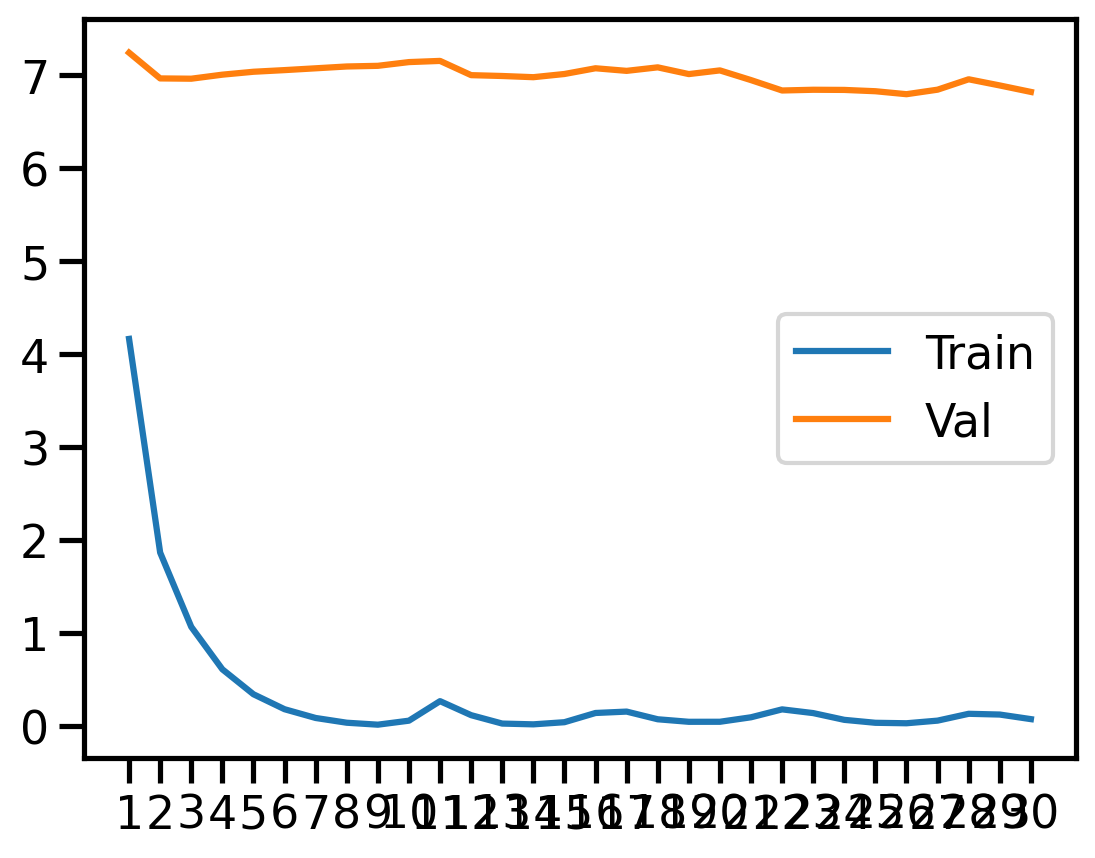

In [43]:
plot_learning_curve(history1)

In [44]:
model1.evaluate(train_dataset)
model1.evaluate(val_dataset)
model1.evaluate(test_dataset)

218/218 [==============================] - 12s 57ms/step - loss: 6.5787 - signal_mse: 2.0099 - vehicle_mse: 11.1438 - avg_mse: 6.5768


[6.578707218170166, 2.009890079498291, 11.143780708312988, 6.576837062835693]

In [45]:
y_train_mobile = model1.predict(train_dataset)
y_val_mobile = model1.predict(val_dataset)
y_test_mobile = model1.predict(test_dataset)

In [46]:
np.savez('y_pred_mobile.npz', y_train_mobile=y_train_mobile,
        y_val_mobile=y_val_mobile, y_test_mobile=y_test_mobile)

## Vanilla CNN

In [66]:
layer1 = tf.keras.layers.Conv2D(6, (2, 2), activation='relu', input_shape=(224, 224, 3))
pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")

layer2 = tf.keras.layers.Conv2D(12, (2, 2), activation='relu')
pooling2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")

layer3 = tf.keras.layers.Conv2D(24, (2, 2), activation='relu')
pooling3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")

layer4 = tf.keras.layers.Conv2D(48, (2, 2), activation='relu')
pooling4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")
dropout = tf.keras.layers.Dropout(0.1)

flatten = tf.keras.layers.Flatten()

dense1 = tf.keras.layers.Dense(units=128, activation='relu')
output = tf.keras.layers.Dense(units=2)

In [72]:
model2 = tf.keras.models.Sequential([
    layer1,
    pooling1,
    dropout,
    layer2,
    pooling2,
    dropout,
    layer3,
    pooling3,
    dropout,
    layer4,
    pooling4,
    flatten,
    dense1,
    output
])
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 223, 223, 6)       78        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 conv2d_16 (Conv2D)          (None, 110, 110, 12)      300       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 55, 55, 12)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 54, 54, 24)      

In [77]:
%%time
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='mean_squared_error',
    metrics=[signal_mse, vehicle_mse, avg_mse],
)

patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',  # Monitor validation loss
                               patience=patience,     # Number of epochs with no improvement after which training will stop
                               restore_best_weights=True)

history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/10
1017/1017 [==============================] - 49s 48ms/step - loss: 1.4617 - signal_mse: 0.8756 - vehicle_mse: 2.0462 - avg_mse: 1.4609 - val_loss: 9.0250 - val_signal_mse: 2.2381 - val_vehicle_mse: 15.8254 - val_avg_mse: 9.0317
Epoch 2/10
1017/1017 [==============================] - 48s 47ms/step - loss: 1.3803 - signal_mse: 0.8657 - vehicle_mse: 1.8935 - avg_mse: 1.3796 - val_loss: 8.9563 - val_signal_mse: 2.2420 - val_vehicle_mse: 15.6834 - val_avg_mse: 8.9627
Epoch 3/10
1017/1017 [==============================] - 49s 48ms/step - loss: 1.3429 - signal_mse: 0.8455 - vehicle_mse: 1.8384 - avg_mse: 1.3419 - val_loss: 9.0785 - val_signal_mse: 2.2462 - val_vehicle_mse: 15.9248 - val_avg_mse: 9.0855
Epoch 4/10
1017/1017 [==============================] - 48s 47ms/step - loss: 1.3341 - signal_mse: 0.8610 - vehicle_mse: 1.8056 - avg_mse: 1.3333 - val_loss: 8.9519 - val_signal_mse: 2.2440 - val_vehicle_mse: 15.6732 - val_avg_mse: 8.9586
Epoch 5/10
1017/1017 [======================

In [78]:
model2.evaluate(train_dataset)

model2.evaluate(val_dataset)
model2.evaluate(test_dataset)

218/218 [==============================] - 8s 39ms/step - loss: 8.3308 - signal_mse: 2.2649 - vehicle_mse: 14.3944 - avg_mse: 8.3297


[8.330766677856445, 2.2649219036102295, 14.394440650939941, 8.329680442810059]

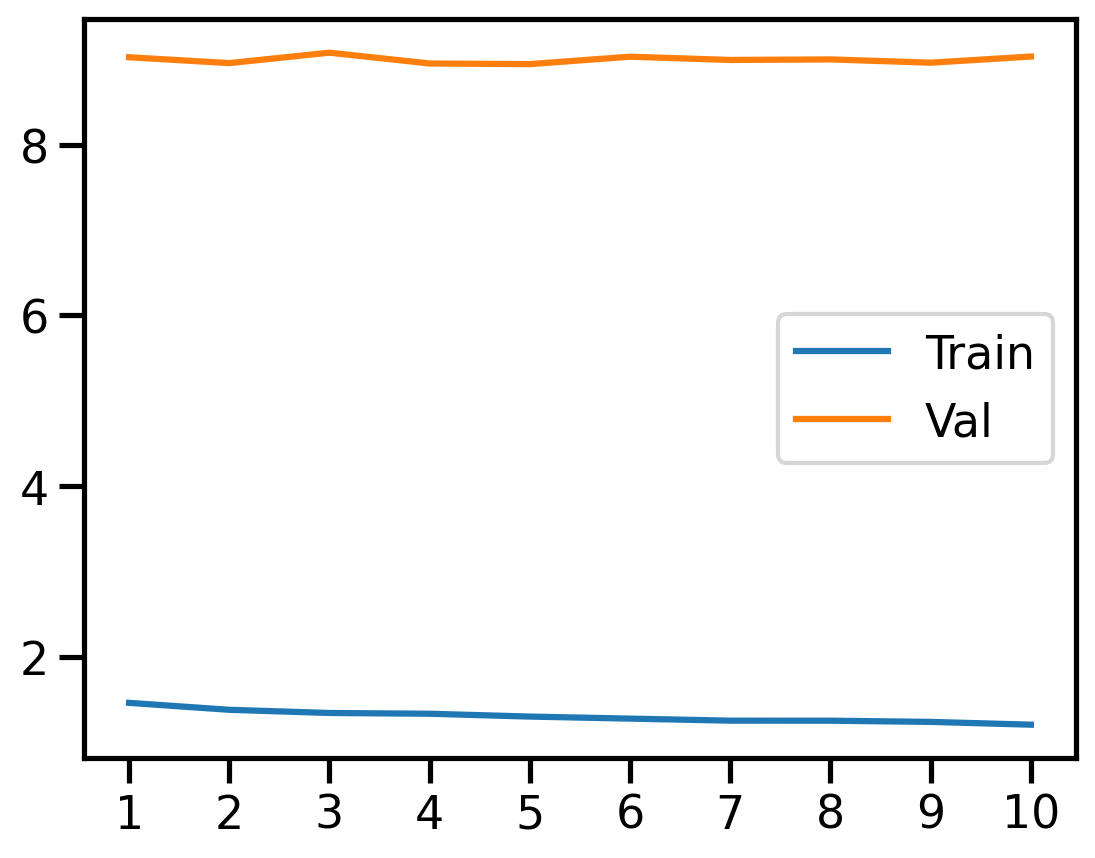

In [79]:
plot_learning_curve(history2)

In [80]:
y_train_cnn = model2.predict(train_dataset)
y_val_cnn = model2.predict(val_dataset)
y_test_cnn = model2.predict(test_dataset)

In [81]:
np.savez('y_pred_cnn.npz', y_train_cnn=y_train_cnn,
        y_val_cnn=y_val_cnn, y_test_cnn=y_test_cnn)

# Ensemble (use linear regression to predict the weight)

We tried different ways of aggregating results, including average results from all models, running linear regression for each output individually, running XGBoost, and building another NN.

We decided to go with NN as it creates the best results.

## Read results

In [82]:
loaded_data = np.load('y_mean.npz')
y_train_mean = loaded_data['y_train_mean']
y_val_mean = loaded_data['y_val_mean']
y_test_mean = loaded_data['y_test_mean']

In [83]:
loaded_data = np.load('y_pred_mobile.npz')
y_train_mobile = loaded_data['y_train_mobile']
y_val_mobile = loaded_data['y_val_mobile']
y_test_mobile = loaded_data['y_test_mobile']

In [84]:
loaded_data = np.load('y_pred_cnn.npz')
y_train_cnn = loaded_data['y_train_cnn']
y_val_cnn = loaded_data['y_val_cnn']
y_test_cnn = loaded_data['y_test_cnn']

In [85]:
X_train_y = np.hstack((y_train_mean, y_train_mobile, y_train_cnn))
X_val_y = np.hstack((y_val_mean, y_val_mobile, y_val_cnn))
X_test_y = np.hstack((y_test_mean, y_test_mobile, y_test_cnn))

In [86]:
y_train = train_md[['signal', 'vehicle']]
y_val = val_md[['signal', 'vehicle']]
y_test = test_md[['signal', 'vehicle']]

## Simple average

### 3 models

In [87]:
y_train_sa = 1/3 * y_train_mean + 1/3 * y_train_mobile +1/3 * y_train_cnn

print(mean_squared_error(y_train, y_train_sa),

mean_squared_error(y_train, y_train_sa, multioutput='raw_values'))

1.738971836327471 [0.71860222 2.75934145]


In [88]:
y_val_sa = 1/3 * y_val_mean + 1/3 * y_val_mobile +1/3 * y_val_cnn

print(mean_squared_error(y_val, y_val_sa),
mean_squared_error(y_val, y_val_sa, multioutput='raw_values'))

7.154837151473759 [ 1.92731544 12.38235887]


In [89]:
y_test_sa = 1/3 * y_test_mean + 1/3 * y_test_mobile +1/3 * y_test_cnn

print(mean_squared_error(y_test, y_test_sa),
mean_squared_error(y_test, y_test_sa, multioutput='raw_values'))

6.644002247678685 [ 1.92940077 11.35860372]


### Mobilenet and vanilla cnn

In [90]:
y_train_sa = 1/2 * y_train_mobile +1/2 * y_train_cnn

print(mean_squared_error(y_train, y_train_sa),

mean_squared_error(y_train, y_train_sa, multioutput='raw_values'))

0.6200645149534891 [0.38500145 0.85512758]


In [91]:
y_val_sa = 1/2 * y_val_mobile +1/2 * y_val_cnn

print(mean_squared_error(y_val, y_val_sa),

mean_squared_error(y_val, y_val_sa, multioutput='raw_values'))

7.074702710351217 [ 1.94386933 12.20553609]


In [92]:
y_test_sa = 1/2 * y_test_mobile +1/2 * y_test_cnn

print(mean_squared_error(y_test, y_test_sa),

mean_squared_error(y_test, y_test_sa, multioutput='raw_values'))

6.630564649804495 [ 1.92836027 11.33276903]


## Linear regression

### Signal

In [93]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_y[:, [0, 2, 4]], y_train.iloc[:, 0])

y_train_pred1 = lr.predict(X_train_y[:, [0, 2, 4]])

In [94]:
mse_train1 = mean_squared_error(y_train.iloc[:, 0], y_train_pred1)
mse_train1

0.24972152207373843

In [95]:
y_val_pred1 = lr.predict(X_val_y[:, [0, 2, 4]])
mse_val1 = mean_squared_error(y_val.iloc[:, 0], y_val_pred1)
mse_val1

1.9520866620525374

In [96]:
y_test_pred1 = lr.predict(X_test_y[:, [0, 2, 4]])
mse_test1 = mean_squared_error(y_test.iloc[:, 0], y_test_pred1)
mse_test1

1.91086377912167

### vehicle

In [97]:
lr2 = LinearRegression()

lr2.fit(X_train_y[:, [1, 3, 5]], y_train.iloc[:, 1])

y_train_pred2 = lr2.predict(X_train_y[:, [1, 3, 5]])

mse_train2 = mean_squared_error(y_train.iloc[:, 1], y_train_pred2)
mse_train2

0.6033175664779712

In [98]:
y_val_pred2 = lr2.predict(X_val_y[:, [1, 3, 5]])
mse_val2 = mean_squared_error(y_val.iloc[:, 1], y_val_pred2)
mse_val2

11.795953108855624

In [99]:
y_test_pred2 = lr2.predict(X_test_y[:, [1, 3, 5]])
mse_test2 = mean_squared_error(y_test.iloc[:, 1], y_test_pred2)
mse_test2

11.019613031913549

### Average

In [100]:
np.mean((mse_train1, mse_train2))

0.4265195442758548

In [101]:
np.mean((mse_val1, mse_val2))

6.87401988545408

In [102]:
np.mean((mse_test1, mse_test2))

6.465238405517609

## XGBoost

In [103]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/ee/2c/03d466d00818c8e0ffcf778946ca4a5e05694a11b85bc51f1bc5c18ca54e/xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.4 MB/s eta 0:00:00:00:0100:01


In [105]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error


xgb_model = xgb.XGBRegressor()

model = MultiOutputRegressor(xgb_model)

param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 5, 7],
    # 'learning_rate': [0.001, 0.0001, 0.00001]
  
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_y, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_y)
mse_train = mean_squared_error(y_train, y_train_pred)
print(f'Mean Squared Error on Validation Set: {mse_train}')

y_val_pred = best_model.predict(X_val_y)


mse_val = mean_squared_error(y_val, y_val_pred)
print(f'Mean Squared Error on Validation Set: {mse_val}')


y_test_pred = best_model.predict(X_test_y)

mse_test = mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error on Test Set: {mse_test}')


print(f'Best Hyperparameters: {grid_search.best_params_}')


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mean Squared Error on Validation Set: 0.3114296686964726
Mean Squared Error on Validation Set: 6.858660878073553
Mean Squared Error on Test Set: 6.582191402245771
Best Hyperparameters: {'estimator__max_depth': 3, 'estimator__n_estimators': 100}


## NN

In [109]:
# layer1 = tf.keras.layers.Dense(units=64, activation='relu',
#                               input_dim=X_train_y.shape[1]
#                               )
# layer2 = tf.keras.layers.BatchNormalization()
# X_train_y_used = X_train_y[:, 2:]

layer1 = tf.keras.layers.Dense(units=64, activation='relu',
                              input_dim=X_train_y.shape[1]
                              )
layer2 = tf.keras.layers.BatchNormalization()

layer3 = tf.keras.layers.Dense(units=32, activation='relu',
                              
                              )
layer4 = tf.keras.layers.BatchNormalization()

output = tf.keras.layers.Dense(units=2)

model3 = tf.keras.models.Sequential([layer1, 
                                     layer2,
                                     layer3,
                                     layer4,
                                     output])


model3.compile(
    optimizer=optimizers.Adam(learning_rate=0.00005),
    loss='mean_squared_error',
    metrics=[signal_mse, vehicle_mse, avg_mse],
)

model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                448       
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,978
Trainable params: 2,786
Non-train

In [110]:
history3 = model3.fit(
    X_train_y, y_train,
    validation_data=(X_val_y, y_val),
    epochs=50,
    shuffle=True,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50
509/509 - 2s - loss: 9.4267 - signal_mse: 1.8501 - vehicle_mse: 16.9846 - avg_mse: 9.4174 - val_loss: 13.3277 - val_signal_mse: 3.0858 - val_vehicle_mse: 23.5648 - val_avg_mse: 13.3253 - 2s/epoch - 4ms/step
Epoch 2/50
509/509 - 1s - loss: 6.4136 - signal_mse: 1.0865 - vehicle_mse: 11.8145 - avg_mse: 6.4505 - val_loss: 12.4777 - val_signal_mse: 3.0896 - val_vehicle_mse: 21.8613 - val_avg_mse: 12.4754 - 1s/epoch - 3ms/step
Epoch 3/50
509/509 - 1s - loss: 5.4670 - signal_mse: 0.9255 - vehicle_mse: 10.0377 - avg_mse: 5.4816 - val_loss: 11.8592 - val_signal_mse: 2.8290 - val_vehicle_mse: 20.8852 - val_avg_mse: 11.8571 - 1s/epoch - 3ms/step
Epoch 4/50
509/509 - 1s - loss: 4.7215 - signal_mse: 0.7709 - vehicle_mse: 8.6687 - avg_mse: 4.7198 - val_loss: 11.0898 - val_signal_mse: 2.6623 - val_vehicle_mse: 19.5130 - val_avg_mse: 11.0876 - 1s/epoch - 3ms/step
Epoch 5/50
509/509 - 1s - loss: 4.0787 - signal_mse: 0.6754 - vehicle_mse: 7.4994 - avg_mse: 4.0874 - val_loss: 10.5361 - val_sig

In [111]:
model3.evaluate(X_train_y, y_train)
model3.evaluate(X_val_y, y_val)
model3.evaluate(X_test_y, y_test)

109/109 [==============================] - 0s 1ms/step - loss: 6.7104 - signal_mse: 1.9617 - vehicle_mse: 11.4570 - avg_mse: 6.7093


[6.710419178009033, 1.961730718612671, 11.456964492797852, 6.709347248077393]

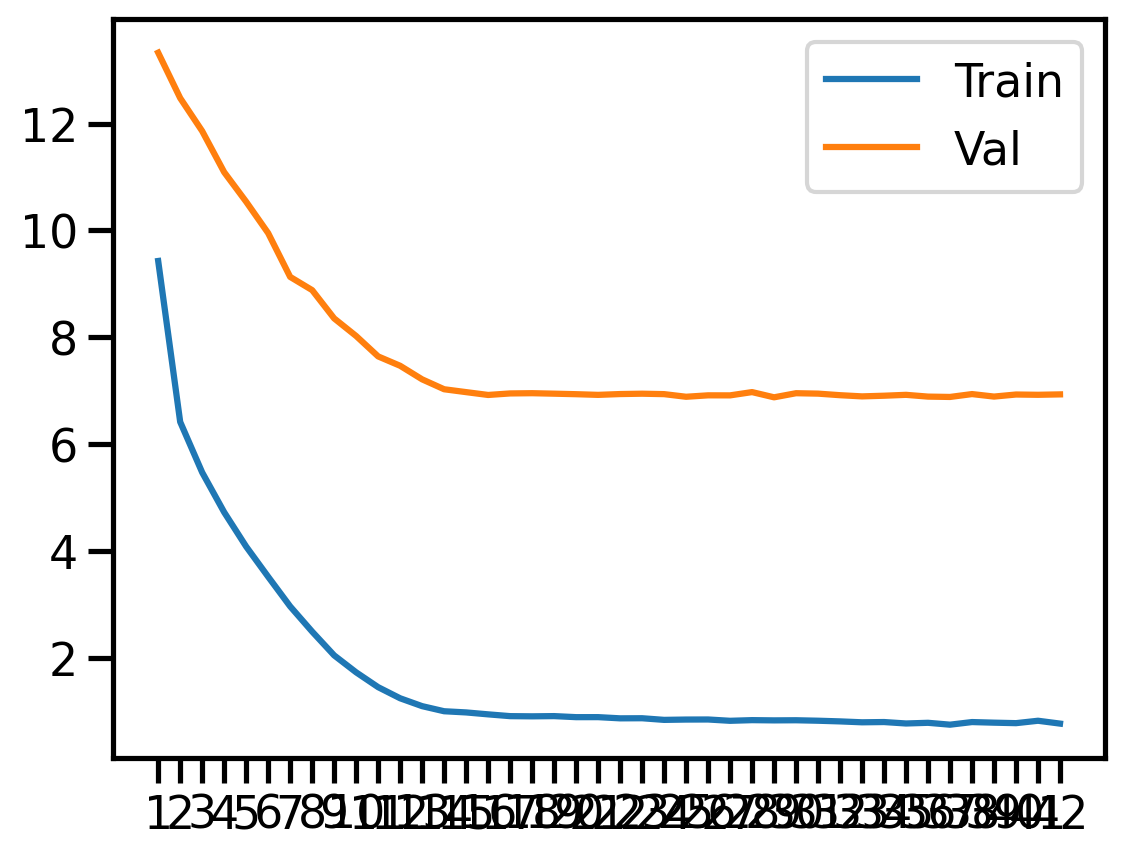

In [112]:
plot_learning_curve(history3)

# Saving the model and predictions

## Final model

In [117]:
import os
import h5py
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

class final_model:
    
    def __init__(self, y_train_mean, model1, model2, model3):
        self.y_train_mean = y_train_mean
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
       
        
    def predict(self, dataset):
        """predict score_dataset with ensemble method"""
        
        
        y_mobile = self.model1.predict(dataset)
        
        y_cnn = self.model2.predict(dataset)
        
        y_train_mean = self.y_train_mean[:y_mobile.shape[0]]
        
        # X_y = np.hstack((y_train_mean, y_mobile, y_cnn))
        X_y = np.hstack((y_train_mean, y_mobile, y_cnn))
        
        y_pred = self.model3.predict(X_y)
        
        return y_pred
    
    def to_json(self):
        # final_model_config = {
        #     'Mobilenet': model1.get_config(),
        #     'Vanilla CNN': model2.get_config(),
        #     'Ensemble NN': model3.get_config()
        # }
        # # # json_string = json.dumps(final_model_config, indent=True)
        # return final_model_config
        
        config1 = self.model1.get_config()
        config2 = self.model2.get_config()
        config3 = self.model3.get_config()

        # Convert NumPy arrays to nested lists
        config1 = json.loads(json.dumps(config1, cls=NumpyEncoder))
        config2 = json.loads(json.dumps(config2, cls=NumpyEncoder))
        config3 = json.loads(json.dumps(config3, cls=NumpyEncoder))

        # Create a dictionary for the final model
        final_model_config = {
            'Mobilenet': config1,
            'Vanilla CNN': config2,
            'Ensemble NN': config3
        }

        # Convert the dictionary to a JSON-formatted string
        json_string = json.dumps(final_model_config, indent=2)

        return json_string
   
    
    def save_weights(self, filepath):
        models = [model1, model2, model3]
    
        temp_dir = "temp_weights"
        os.makedirs(temp_dir, exist_ok=True)

        # Save weights of each model in the temporary directory
        model_weights_paths = []
        for i, model in enumerate(models):
            temp_filepath = os.path.join(temp_dir, f"temp_model_{i}.h5")
            model.save_weights(temp_filepath)
            model_weights_paths.append(temp_filepath)

        # Combine individual model weights into one file
        with h5py.File(filepath, 'w') as combined_weights_file:
            for i, model_weights_path in enumerate(model_weights_paths):
                with h5py.File(model_weights_path, 'r') as temp_weights_file:
                    # Copy each group from the temporary file to the combined file
                    for key in temp_weights_file.keys():
                        combined_weights_file.copy(
                            temp_weights_file[key], f"model_{i}/{key}"
                        )

        # Remove the temporary directory
        for temp_weights_path in model_weights_paths:
            os.remove(temp_weights_path)
        os.rmdir(temp_dir)



## Creating TF Score Dataset

In [114]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_score(metadata: pd.DataFrame):
    def generator():
        for _, row in metadata.iterrows():
            
            # get image
            file_path = 'carnet_dataset/score/images/' + row['file_name']
            score_np = np.array(Image.open(file_path)).astype(np.float32)
        
            model_input = score_np
           
            yield model_input


    return generator


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_score(metadata: pd.DataFrame) -> tf.data.Dataset:
    model_input = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore


    dataset_signature = model_input

    dataset = tf.data.Dataset.from_generator(
        build_generator_score(metadata), 
        output_signature=dataset_signature
    )

    return dataset


In [115]:
score_metadata = pd.read_csv('carnet_dataset/score/metadata.csv')

score_dataset = build_dataset_score(score_metadata).batch(16)

model_input = next(iter(score_dataset))

display(model_input.shape)

TensorShape([16, 224, 224, 3])

In [116]:
score_metadata.head()

,file_name
0,000000000071.jpg
1,000000000149.jpg
2,000000000260.jpg
3,000000000307.jpg
4,000000000690.jpg


## Predict score dataset

In [118]:
model = final_model(y_train_mean, model1, model2, best_model)

In [119]:
score_y_pred = model.predict(score_dataset)

In [120]:
score_y_pred

array([[-2.8860420e-02,  9.6137543e+00],
       [-7.9406183e-03,  2.0815887e+00],
       [ 9.6180536e-02,  2.8782840e+00],
       ...,
       [ 4.8932362e-01,  3.2557108e+00],
       [ 9.8347741e-01,  2.7869747e+00],
       [ 5.5158299e-01,  2.5088494e+00]], dtype=float32)

In [121]:
score_y_hat = pd.DataFrame(score_y_pred, columns=['signal', 'vehicle'])

In [122]:
# Save your predictions on the Score segment as a Pandas data frame into a variable named `score_y_hat`.
# The data frame should contain 2 columns: signal and vehicle.
# The following is an EXAMPLE of what this data frame could be.
# score_y_hat = pd.DataFrame({
#     'signal': [0] * score_metadata.shape[0],
#     'vehicle': [0] * score_metadata.shape[0]
# })

# Use the following asserts to check the type and shape of the final predictions.
assert type(score_y_hat) == pd.DataFrame
assert score_y_hat.shape == (score_metadata.shape[0], 2)
assert (score_y_hat.columns == ['signal', 'vehicle']).all()

# Use the following code to save the final predictions.
import os 
model_dir = 'carnet_model'
os.makedirs(model_dir, exist_ok=True)
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

In [132]:
best_model.estimators_[0].get_booster().save_config()

'{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"100"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"3","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch_ratio":"2","sparse

In [138]:
best_model.estimators_[0].get_booster().save_model('try.model')

/app/conda/envs/collegium/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:03:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [140]:
# separate models
import json

for i, model in enumerate([model1, model2, best_model]):
    with open(f'{model_dir}/keras_model{i+1}.json', 'w') as f:
        if model != best_model:
            model_json = json.dumps(json.loads(model.to_json()), indent=True)
            f.write(model_json)
        else:
            model_config = best_model.estimators_[0].get_booster().save_config()
            json.dump(model_config, f, indent=2)

    # Save the learned parameters.
    if model != best_model:
        model.save_weights(f"{model_dir}/keras_parameters_model{i+1}.h5")
    else:
        best_model.estimators_[0].get_booster().save_model(f"{model_dir}/keras_parameters_model{i+1}.h5")

/app/conda/envs/collegium/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:04:34] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [124]:
# # ensemble
# import json
# with open(f'{model_dir}/keras_model.json', 'w') as f:
#     # model_json = json.dumps(json.loads(model.to_json()), indent=True)
#     model_json = json.dumps(json.loads(model.to_json()), indent=True)
#     f.write(model_json)

# # Save the learned parameters.
# model.save_weights(f"{model_dir}/keras_parameters.h5")

In [478]:
# Next, save each model's defition (JSON file) and parameters (H5 file).

In [479]:
# You now have the following files to be submit:
# 1. This notebook and any other Python code you used to train the final model.
# 2. definitions of all trained models
# 3. parameters of all trained models
# 4. score_y_hat.parquet - the model's output on the score segment